In [1]:
import pandas as pd
import anndata as ad
from scipy import io
import scipy.sparse as sp

# 1) Load the files
counts = io.mmread("scPrint2_PR_counts.mtx")
counts = counts.tocsr() if sp.issparse(counts) else sp.csr_matrix(counts)

genes = pd.read_csv("scPrint2_PR_genes.tsv", sep="\t", header=None)
meta  = pd.read_csv("scPrint2_PR_meta.csv", index_col=0)

# Clean gene table
genes = genes.copy()
genes.iloc[:, 0] = genes.iloc[:, 0].astype(str).str.strip()

# If there's a 1-row header artifact, drop it
r, c = counts.shape
g = genes.shape[0]

if g == r + 1:
    genes = genes.iloc[1:].reset_index(drop=True)
    g = genes.shape[0]
elif g == c + 1:
    genes = genes.iloc[1:].reset_index(drop=True)
    g = genes.shape[0]

# Name gene column (assumes 1-col gene file; adjust if your file has 2 cols)
if genes.shape[1] != 1:
    raise ValueError(f"genes.tsv has {genes.shape[1]} columns; update parsing to handle this.")
genes.columns = ["gene_id"]

# Basic cleanliness for meta
meta = meta.copy()
meta.index = meta.index.astype(str).str.strip()

print("counts shape:", counts.shape)
print("genes shape: ", genes.shape)
print("meta shape:  ", meta.shape)

# 2) Decide orientation (we want cells x genes)
n_cells = meta.shape[0]
n_genes = genes.shape[0]

if (r == n_genes) and (c == n_cells):
    X = counts.T.tocsr()
    print("Orientation: genes x cells → transposed to cells x genes")
elif (r == n_cells) and (c == n_genes):
    X = counts.tocsr()
    print("Orientation: cells x genes → using as-is")
else:
    raise ValueError(
        "Dimension mismatch:\n"
        f"  counts: {counts.shape}\n"
        f"  genes:  {n_genes}\n"
        f"  meta:   {n_cells}\n"
        "Cannot safely infer orientation. You likely need barcodes.tsv or a different export."
    )

# Hard dimension checks
if X.shape[0] != n_cells:
    raise ValueError(f"X has {X.shape[0]} rows but meta has {n_cells} rows (cells).")
if X.shape[1] != n_genes:
    raise ValueError(f"X has {X.shape[1]} cols but genes has {n_genes} rows (genes).")

# 3) Ensure obs names are unique (required)
preferred_id_cols = ["barcode", "barcodes", "cell", "cell_id", "CellID", "CellID_unique"]
id_col = next((col for col in preferred_id_cols if col in meta.columns), None)

if id_col is not None:
    meta[id_col] = meta[id_col].astype(str).str.strip()
    if meta[id_col].duplicated().any():
        raise ValueError(
            f"Found '{id_col}' column but it contains duplicates. "
            "Use a different unique ID column or combine sample+barcode."
        )
    meta.index = meta[id_col]
else:
    if meta.index.duplicated().any():
        s = pd.Series(meta.index, index=meta.index)
        meta.index = meta.index + "_" + s.groupby(level=0).cumcount().astype(str)
        meta.index = meta.index.str.replace(r"_0$", "", regex=True)

if not meta.index.is_unique:
    raise ValueError("Failed to make meta index unique; inspect meta for duplicate cell IDs.")

# 4) Build AnnData with obs/var immediately
var = pd.DataFrame(index=genes["gene_id"].astype(str).values)
adata = ad.AnnData(X=X, obs=meta, var=var)

# Make names clean + unique
adata.var_names = adata.var_names.astype(str).str.strip()
adata.var_names_make_unique()

adata.obs_names = adata.obs.index.astype(str)
adata.obs_names_make_unique()  # should already be unique, but harmless safeguard

print(adata)

# Save
adata.write_h5ad("scPrint2_forLIANA.h5ad")
print("Wrote file: scPrint2_forLIANA.h5ad")

counts shape: (18082, 194199)
genes shape:  (18082, 1)
meta shape:   (194199, 13)
Orientation: genes x cells → transposed to cells x genes
AnnData object with n_obs × n_vars = 194199 × 18082
    obs: 'nCount_Spatial.008um', 'nFeature_Spatial.008um', 'CaptureArea', 'CellType', 'PrintPattern', 'CultureCondition', 'CellLine', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'CellID'
Wrote file: scPrint2_forLIANA.h5ad


In [2]:
import re
import scanpy as sc
import anndata as ad
import liana as li
import pandas as pd

In [3]:
# Load the h5ad we already created
adata = ad.read_h5ad("scPrint2_forLIANA.h5ad")

# Make obs names unique to silence warnings
adata.obs_names_make_unique()

# Metadata standardization 
required = ["CellType", "CultureCondition", "PrintPattern"]
missing = [c for c in required if c not in adata.obs.columns]
if missing:
    raise ValueError(f"Missing required obs columns: {missing}\nFound: {adata.obs.columns.tolist()}")

def make_sample_from_printpattern(x: str) -> str:
    x = str(x)
    m = re.search(r"(Pattern|Random)\s*[_-]?\s*(\d+)", x, flags=re.IGNORECASE)
    if m:
        return f"{m.group(1).capitalize()}_{m.group(2)}"
    return x

# Create per-replicate sample ID for LIANA's sample aware aggregation
adata.obs["sample"] = adata.obs["PrintPattern"].map(make_sample_from_printpattern)

# Create condition column
adata.obs["condition"] = adata.obs["CultureCondition"].astype(str)
adata.obs["condition"] = adata.obs["condition"].replace({"pattern": "Pattern", "random": "Random"})

# Stable raw counts layer for rank_aggregate 
if "counts" not in adata.layers:
    adata.layers["counts"] = adata.X.copy()

print("condition counts:")
print(adata.obs["condition"].value_counts(dropna=False))

print("\nsample (first 20 unique):")
print(sorted(adata.obs["sample"].unique())[:20])

# Summary
adata  

condition counts:
condition
Random     98415
Pattern    95784
Name: count, dtype: int64

sample (first 20 unique):
['Pattern_1', 'Pattern_2', 'Pattern_3', 'Random_1', 'Random_2', 'Random_3']


AnnData object with n_obs × n_vars = 194199 × 18082
    obs: 'nCount_Spatial.008um', 'nFeature_Spatial.008um', 'CaptureArea', 'CellType', 'PrintPattern', 'CultureCondition', 'CellLine', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'CellID', 'sample', 'condition'
    layers: 'counts'

In [4]:
# Keep only Pattern + Random cultures
keep_cc = ["Pattern", "Random"]
adata_cc = adata[adata.obs["condition"].isin(keep_cc)].copy()

# Remove any unlabeled cells
adata_cc = adata_cc[adata_cc.obs["CellType"] != "Unlabeled"].copy()

print("condition counts:")
print(adata_cc.obs["condition"].value_counts())

print("\nCellType counts:")
print(adata_cc.obs["CellType"].value_counts())

print("\nSamples per condition:")
print(adata_cc.obs.groupby("condition")["sample"].nunique())

condition counts:
condition
Random     98119
Pattern    95784
Name: count, dtype: int64

CellType counts:
CellType
Fibroblast    175162
MCF7           11954
MCF10A          6787
Name: count, dtype: int64

Samples per condition:
condition
Pattern    3
Random     3
Name: sample, dtype: int64


In [5]:
adata_pat  = adata_cc[adata_cc.obs["condition"] == "Pattern"].copy()
adata_rand = adata_cc[adata_cc.obs["condition"] == "Random"].copy()

print(f"Pattern cells: {adata_pat.n_obs}")
print(f"Random cells:  {adata_rand.n_obs}")

Pattern cells: 95784
Random cells:  98119


In [6]:
# Help here: https://liana-py.readthedocs.io/en/latest/notebooks/basic_usage.html

def run_liana_one_condition(adata_in):
    """
    Run LIANA rank_aggregate on an AnnData object,
    grouping by CellType and using the consensus LR resource.
    """
    adata_work = adata_in.copy()

    # Use raw counts as the starting point
    adata_work.X = adata_work.layers["counts"].copy()

    sc.pp.normalize_total(adata_work, target_sum=1e4)
    sc.pp.log1p(adata_work)

    li.mt.rank_aggregate(
        adata_work,
        groupby="CellType",
        resource_name="consensus",
        expr_prop=0.1,
        use_raw=False,
        n_perms=1000,
        inplace=True,
        verbose=True,
    )

    return adata_work.uns["liana_res"].copy()

In [7]:
print("Running LIANA on Pattern...")
res_pat = run_liana_one_condition(adata_pat)

print("\nRunning LIANA on Random...")
res_rand = run_liana_one_condition(adata_rand)


Running LIANA on Pattern...


Using resource `consensus`.
Using `.X`!
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2769 features of mat are empty, they will be removed.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.26 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 95784 samples and 1263 features


/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:270: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:275: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:278: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.30it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR

Running LIANA on Random...


Using resource `consensus`.
Using `.X`!
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2393 features of mat are empty, they will be removed.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.23 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 98119 samples and 1325 features


/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:270: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:275: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.
/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:278: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.86it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [8]:
print("Pattern result head:")
print(res_pat.head())

print("\nRandom result head:")
print(res_rand.head())

res_pat.to_csv("scPrint2_liana_Pattern_rank_aggregate.csv", index=False)
res_rand.to_csv("scPrint2_liana_Random_rank_aggregate.csv", index=False)

print("\nSaved LIANA results to CSV.")

Pattern result head:
         source      target ligand_complex receptor_complex  lr_means  \
75       MCF10A  Fibroblast         COL1A1             CD44  2.257597   
2    Fibroblast  Fibroblast         COL1A1             CD44  2.251403   
144        MCF7  Fibroblast         COL1A1             CD44  2.244673   
29   Fibroblast  Fibroblast            VIM             CD44  2.200648   
27   Fibroblast  Fibroblast          TIMP1             CD63  2.183993   

     cellphone_pvals  expr_prod  scaled_weight  lr_logfc  spec_weight  \
75             0.220   2.644313       0.005017  0.110418     0.121110   
2              0.014   2.635745       0.001958  0.163380     0.120718   
144            0.570   2.626437      -0.001366  0.065360     0.120292   
29             0.000   2.565543       0.010656  0.313814     0.130292   
27             0.000   3.063441       0.007037  0.238492     0.126913   

      lrscore  specificity_rank  magnitude_rank  
75   0.975418          0.013066        0.007633  
2

In [9]:
def select_top_interactions(df, n_top=30):
    """
    Select the top n_top interactions from a LIANA result DataFrame.
    """
    df = df.copy()

    # in LIANA, lower magnitude_rank is better
    if "magnitude_rank" in df.columns:
        df_sorted = df.sort_values("magnitude_rank", ascending=True)
    # in LIANA, lower aggregate rank is better
    elif "aggregate_rank" in df.columns:
        df_sorted = df.sort_values("aggregate_rank", ascending=True)
    # in LIANA, higher lrscore means stronger interaction
    elif "lrscore" in df.columns:
        df_sorted = df.sort_values("lrscore", ascending=False)
    else:
        raise ValueError(
        "No recognized ranking columns found. "
        "Expected one of: magnitude_rank, aggregate_rank, lrscore."
        )

    return df_sorted.head(n_top)

In [10]:
# Convert LIANA’s ligand–receptor inference results into a weighted cell–cell interaction network by aggregating interaction-level evidence between sender and receiver cell types

def make_cell_cell_edges(df, weight_mode="count"):
    """
    Collapse LIANA LR table into a cell→cell weighted edge list.

    weight_mode:
      - "count"  : number of LR pairs between source/target 
      - "sum_inv_rank": sum(1 / magnitude_rank) per source/target
    """
    df = df.copy()

    if weight_mode == "count":
        edges = (
            df.groupby(["source", "target"])
              .size()
              .reset_index(name="weight")
        )

    elif weight_mode == "sum_inv_rank":
        if "magnitude_rank" not in df.columns:
            raise ValueError("magnitude_rank not in LIANA result.")
        df["inv_rank"] = 1.0 / df["magnitude_rank"].astype(float)
        edges = (
            df.groupby(["source", "target"])["inv_rank"]
              .sum()
              .reset_index(name="weight")
        )
    else:
        raise ValueError("Unknown weight_mode")

    return edges


# Pattern and Random cell–cell edge tables
edges_pat  = make_cell_cell_edges(res_pat,  weight_mode="count")
edges_rand = make_cell_cell_edges(res_rand, weight_mode="count")

print("Pattern edges:")
print(edges_pat.head())

print("\nRandom edges:")
print(edges_rand.head())

# Save for R / circos
edges_pat.to_csv("scPrint2_Pattern_cellcell_edges.csv", index=False)
edges_rand.to_csv("scPrint2_Random_cellcell_edges.csv", index=False)

print("Wrote scPrint2_Pattern_cellcell_edges.csv and scPrint2_Random_cellcell_edges.csv")

Pattern edges:
       source      target  weight
0  Fibroblast  Fibroblast      30
1  Fibroblast      MCF10A      29
2  Fibroblast        MCF7      16
3      MCF10A  Fibroblast      27
4      MCF10A      MCF10A      26

Random edges:
       source      target  weight
0  Fibroblast  Fibroblast      29
1  Fibroblast      MCF10A      16
2  Fibroblast        MCF7      29
3      MCF10A  Fibroblast      29
4      MCF10A      MCF10A      16
Wrote scPrint2_Pattern_cellcell_edges.csv and scPrint2_Random_cellcell_edges.csv


In [11]:
# MOVED THE DATA VIZ TO R 

#

#

#

# Made a Circos Plot
# using scPrint2_Pattern_cellcell_edges.csv and scPrint2_Random_cellcell_edges.csv

In [12]:
# Create copy
adata_pat.uns["liana_res"] = res_pat.copy()
adata_rand.uns["liana_res"] = res_rand.copy()

/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/plotting/_common.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


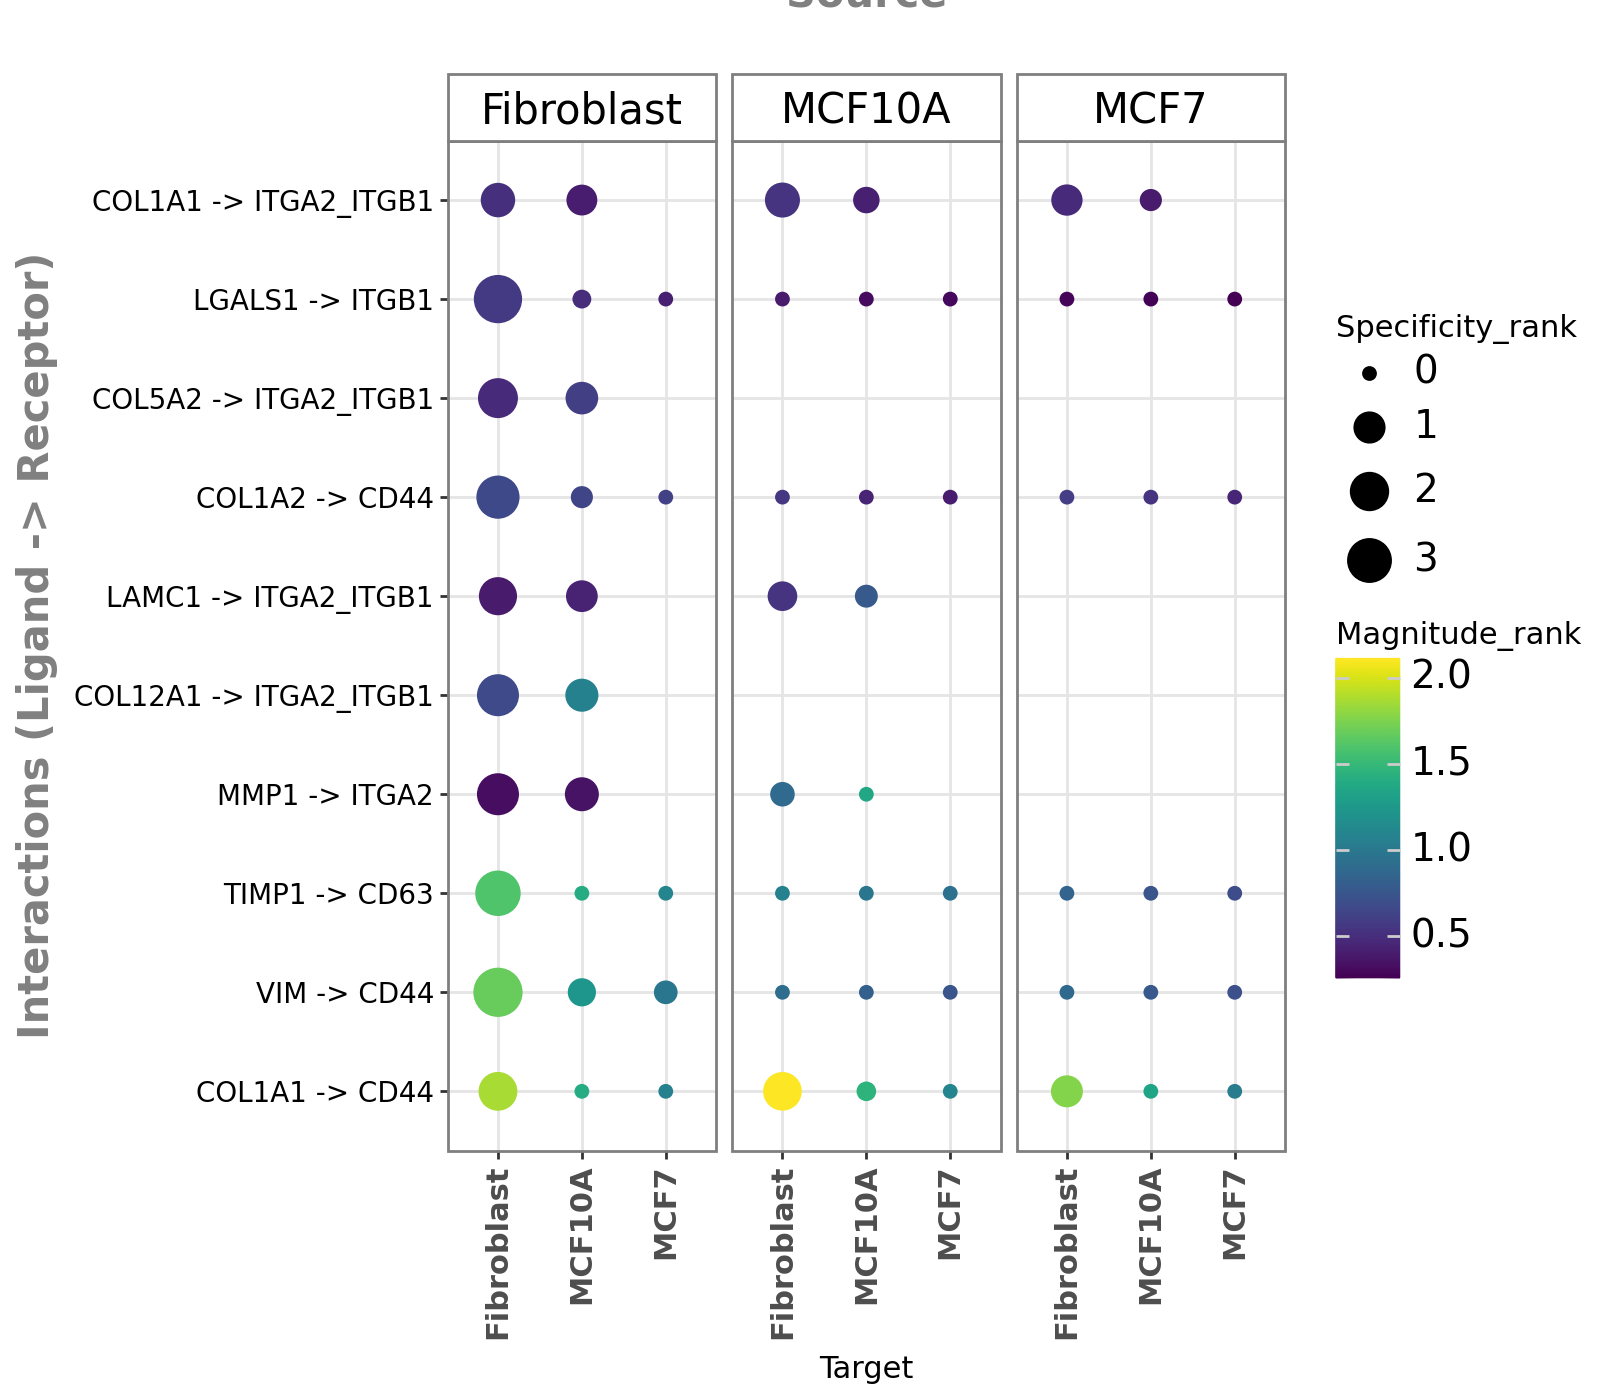

In [13]:
# Dot plot pattern
import liana as li

li.pl.dotplot(
    adata=adata_pat,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_size=True,
    inverse_colour=True,
    source_labels=["MCF10A", "Fibroblast", "MCF7"],
    target_labels=["MCF7", "MCF10A", "Fibroblast"],
    top_n=10,
    orderby="magnitude_rank",
    orderby_ascending=True,
    figure_size=(8, 7),
    uns_key="liana_res")


/home/helmsh/miniconda3/envs/liana_env/lib/python3.11/site-packages/liana/plotting/_common.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


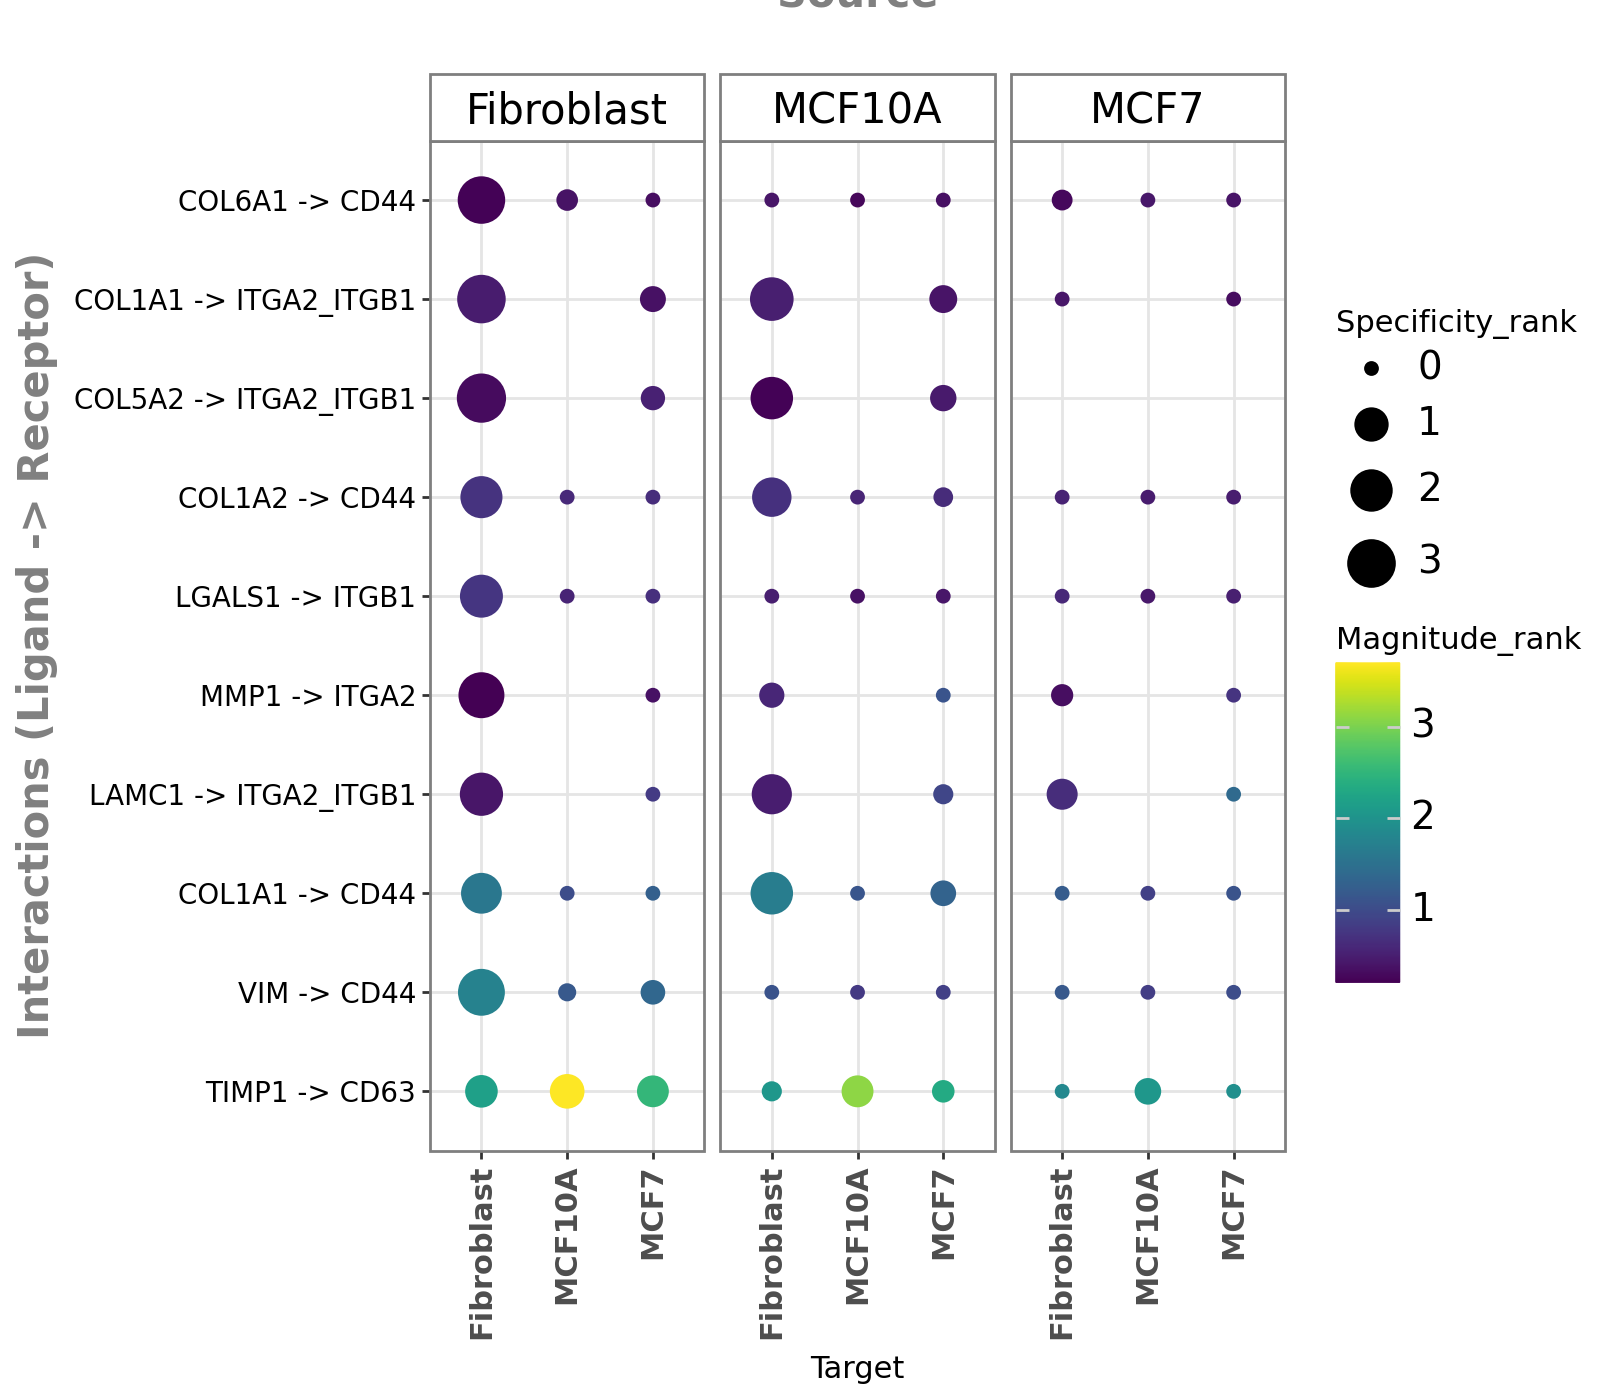

In [14]:
# Dot plot random
li.pl.dotplot(
    adata=adata_rand,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_size=True,
    inverse_colour=True,
    source_labels=["MCF10A", "Fibroblast", "MCF7"],
    target_labels=["MCF7", "MCF10A", "Fibroblast"],
    top_n=10,
    orderby="magnitude_rank",
    orderby_ascending=True,
    figure_size=(8, 7),
    uns_key="liana_res")

In [15]:
# MOVED THE DATA VIZ TO R 

#

#

#

# Made a global overview dot plot directly comparing Pattern vs Random as the X axis variables
# using scPrint2_liana_Pattern_rank_aggregate.csv and scPrint2_liana_Random_rank_aggregate.csv

In [16]:
# Build sender→receiver rewiring table from precomputed edge CSVs 
import pandas as pd

# Load cell–cell edge tables from earlier steps
edges_pat = pd.read_csv("scPrint2_Pattern_cellcell_edges.csv")
edges_rand = pd.read_csv("scPrint2_Random_cellcell_edges.csv")

# Basic sanity checks
required_cols = {"source", "target", "weight"}
missing_pat = required_cols - set(edges_pat.columns)
missing_rand = required_cols - set(edges_rand.columns)

if missing_pat:
    raise ValueError(
        f"Pattern edges file is missing columns: {sorted(missing_pat)} "
        f"(has: {list(edges_pat.columns)})"
    )
if missing_rand:
    raise ValueError(
        f"Random edges file is missing columns: {sorted(missing_rand)} "
        f"(has: {list(edges_rand.columns)})"
    )

print("Pattern edges shape:", edges_pat.shape)
print("Random edges shape :", edges_rand.shape)

# Merge Pattern and Random edges and compute rewiring
df = (
    edges_pat.rename(columns={"weight": "weight_pat"})
    .merge(
        edges_rand.rename(columns={"weight": "weight_rand"}),
        on=["source", "target"],
        how="outer",
    )
    .fillna(0)
)

# Rewiring metrics
df["delta"] = df["weight_pat"] - df["weight_rand"]   # Pattern − Random
df["abs_delta"] = df["delta"].abs()

# Sort by strongest rewiring
df = df.sort_values("abs_delta", ascending=False).reset_index(drop=True)

print("Rewiring table (head):")
print(df.head())

# Build plot_df and export
plot_df = df.copy()
plot_df["pair"] = plot_df["source"].astype(str) + " → " + plot_df["target"].astype(str)

plot_df.to_csv("scPrint2_rewiring_dotplot_data.csv", index=False)
print("Saved: scPrint2_rewiring_dotplot_data.csv")

Pattern edges shape: (9, 3)
Random edges shape : (9, 3)
Rewiring table (head):
       source  target  weight_pat  weight_rand  delta  abs_delta
0        MCF7    MCF7          14           28    -14         14
1      MCF10A    MCF7          15           29    -14         14
2  Fibroblast  MCF10A          29           16     13         13
3  Fibroblast    MCF7          16           29    -13         13
4      MCF10A  MCF10A          26           16     10         10
Saved: scPrint2_rewiring_dotplot_data.csv


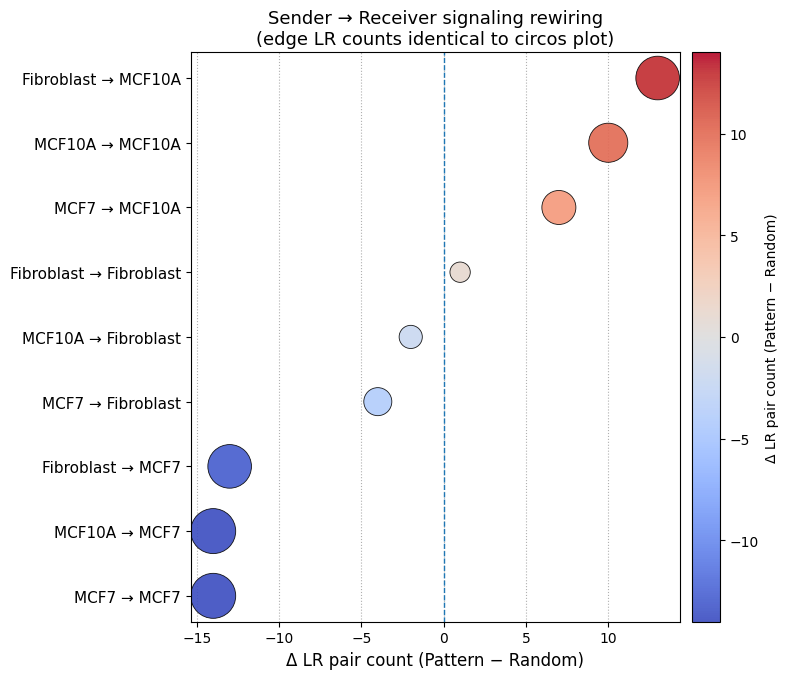

Saved: scPrint2_rewiring_dotplot_MATCHES_CIRCOS.png


In [17]:
# Quick Viz: dot plot of rewiring using plot_df
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load from the CSV we just created
plot_df = pd.read_csv("scPrint2_rewiring_dotplot_data.csv")

# Order pairs by abs_delta (strongest rewiring first)
TOP_K = 30  # adjust if you want more / fewer pairs
plot_top = plot_df.sort_values("abs_delta", ascending=False).head(TOP_K).copy()

# For plotting, sort by delta so negative/positive are structured along x
plot_top = plot_top.sort_values("delta", ascending=True)

y = np.arange(len(plot_top))

delta = plot_top["delta"].to_numpy()
abs_delta = plot_top["abs_delta"].to_numpy()

# Dot size scaled by |delta|
if abs_delta.max() > 0:
    sizes = 150 + 900 * (abs_delta / abs_delta.max())
else:
    sizes = np.full_like(abs_delta, 300.0)

v = np.max(np.abs(delta)) if np.max(np.abs(delta)) > 0 else 1.0

fig, ax = plt.subplots(figsize=(8, 0.6 * len(plot_top) + 1.5))

sc = ax.scatter(
    delta,
    y,
    s=sizes,
    c=delta,
    cmap="coolwarm",
    vmin=-v,
    vmax=v,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.9,
)

ax.axvline(0, linestyle="--", linewidth=1)

ax.set_yticks(y)
ax.set_yticklabels(plot_top["pair"], fontsize=11)

ax.set_xlabel("Δ LR pair count (Pattern − Random)", fontsize=12)
ax.set_title(
    "Sender → Receiver signaling rewiring\n"
    "(edge LR counts identical to circos plot)",
    fontsize=13,
)

ax.grid(True, axis="x", linestyle=":", linewidth=0.8)
ax.set_axisbelow(True)

cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("Δ LR pair count (Pattern − Random)", rotation=90)

plt.tight_layout()
plt.savefig("scPrint2_rewiring_dotplot_MATCHES_CIRCOS.png",
            dpi=300, bbox_inches="tight")
plt.show()

print("Saved: scPrint2_rewiring_dotplot_MATCHES_CIRCOS.png")

In [18]:
# MOVED THE DATA VIZ TO R 

#

#

#

# Made Pairwise rewiring plot using scPrint2_rewiring_dotplot_data.csv

In [20]:
# TF / PROGENy activity and OmniPath LR resource (for Sankey plot)
import numpy as np
import pandas as pd
import decoupler as dc
import scanpy as sc
import omnipath as op

# Helper: make a log1p matrix for decoupler (from counts)
def prep_log1p_from_counts(ad_in, layer="counts", target_sum=1e4):
    ad = ad_in.copy()
    X = ad.layers[layer] if layer in ad.layers else ad.X
    ad.X = X.copy()
    sc.pp.normalize_total(ad, target_sum=target_sum)
    sc.pp.log1p(ad)
    return ad

# Helper: build expression df for decoupler (cells x genes)
# Only keeps genes that appear in the network targets
def expr_df_for_net(ad, net, target_col="target"):
    genes = pd.Index(ad.var_names.astype(str))
    net_genes = pd.Index(pd.unique(net[target_col].astype(str)))
    use_genes = genes.intersection(net_genes)

    if len(use_genes) == 0:
        raise ValueError(
            "No overlap between adata.var_names and network target genes.\n"
            f"Example adata genes: {genes[:5].tolist()}\n"
            f"Example net targets: {net_genes[:5].tolist()}"
        )

    sub = ad[:, use_genes].copy()
    X = sub.X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X)

    return pd.DataFrame(X, index=sub.obs_names.astype(str), columns=use_genes.astype(str))

# Helper: run decoupler method and return (est_df, pval_df_or_None)
def run_decoupler_safe(method_fn, *, data, net, **kwargs):
    out = method_fn(data=data, net=net, **kwargs)

    if out is None:
        raise RuntimeError(
            f"{method_fn.__name__} returned None. "
            "This usually means the method crashed internally or produced no results."
        )

    if isinstance(out, tuple) and len(out) == 2:
        est, pvals = out
        return est, pvals

    if isinstance(out, pd.DataFrame):
        return out, None

    if isinstance(out, dict):
        est = out.get("estimate", out.get("estimates", None))
        pvs = out.get("pvals", out.get("p_values", None))
        if est is None:
            raise RuntimeError(
                f"{method_fn.__name__} returned dict without estimates keys: {list(out.keys())}"
            )
        return est, pvs

    raise RuntimeError(f"Unexpected output type from {method_fn.__name__}: {type(out)}")

# Helper: align decoupler estimates to AnnData obs
def store_activity_in_obsm(ad, est_df, obsm_key, uns_cols_key):
    if not isinstance(est_df, pd.DataFrame):
        est_df = pd.DataFrame(np.asarray(est_df))

    est_df.index = est_df.index.astype(str)
    ad_idx = ad.obs_names.astype(str)

    est_aligned = est_df.reindex(ad_idx)

    n_missing = int(est_aligned.isna().all(axis=1).sum())
    if n_missing > 0:
        print(
            f"WARNING: {obsm_key}: {n_missing} cells missing in decoupler output. "
            "Filling NaNs with 0."
        )
        est_aligned = est_aligned.fillna(0)

    ad.obsm[obsm_key] = est_aligned.to_numpy()
    ad.uns[uns_cols_key] = est_aligned.columns.astype(str).tolist()

# Receiver-only objects (MCF7)
TARGET_CT = "MCF7"

adata_cc.var_names_make_unique()
adata_mcf7 = adata_cc[adata_cc.obs["CellType"].astype(str) == TARGET_CT].copy()

adata_mcf7_pat  = prep_log1p_from_counts(
    adata_mcf7[adata_mcf7.obs["condition"] == "Pattern"].copy(),
    layer="counts"
)
adata_mcf7_rand = prep_log1p_from_counts(
    adata_mcf7[adata_mcf7.obs["condition"] == "Random"].copy(),
    layer="counts"
)

# Load shared resources
# CollecTRI TF network
def load_collectri_net():
    # Prefer new API if available
    if hasattr(dc, "get_collectri"):
        return dc.get_collectri(organism="human", split_complexes=True)
    # Fallback to old API
    if hasattr(dc, "op") and hasattr(dc.op, "collectri"):
        return dc.op.collectri(
            organism="human",
            remove_complexes=False,
            license="academic",
            verbose=False,
        )
    raise RuntimeError("No CollecTRI loader found in this decoupler version.")

# PROGENy pathway network
def load_progeny_net():
    if hasattr(dc, "get_progeny"):
        return dc.get_progeny(organism="human", top=100)
    if hasattr(dc, "op") and hasattr(dc.op, "progeny"):
        return dc.op.progeny(organism="human", top=100, verbose=False)
    raise RuntimeError("No PROGENy loader found in this decoupler version.")

tf_net = load_collectri_net()
progeny_net = load_progeny_net()

print("TF net shape:", tf_net.shape)
print("PROGENy net shape:", progeny_net.shape)

# OmniPath ligand–receptor resource (for LR categories)
try:
    omni_lr = op.interactions.import_intercell_network(
        genesymbols_only=True
    )
except TypeError:
    print(
        "import_intercell_network does not accept `genesymbols_only`; "
        "calling without arguments and will handle symbols downstream."
    )
    omni_lr = op.interactions.import_intercell_network()

print("OmniPath LR table shape:", omni_lr.shape)

# TF activity (CollecTRI) via ULM
X_pat_tf = expr_df_for_net(adata_mcf7_pat, tf_net, target_col="target")
X_ran_tf = expr_df_for_net(adata_mcf7_rand, tf_net, target_col="target")

tf_est_pat, tf_p_pat   = run_decoupler_safe(dc.mt.ulm, data=X_pat_tf, net=tf_net, tmin=5, verbose=False)
tf_est_rand, tf_p_rand = run_decoupler_safe(dc.mt.ulm, data=X_ran_tf, net=tf_net, tmin=5, verbose=False)

store_activity_in_obsm(adata_mcf7_pat,  tf_est_pat,  obsm_key="tf_ulm", uns_cols_key="tf_ulm_cols")
store_activity_in_obsm(adata_mcf7_rand, tf_est_rand, obsm_key="tf_ulm", uns_cols_key="tf_ulm_cols")

print("TF ULM shapes:", adata_mcf7_pat.obsm["tf_ulm"].shape, adata_mcf7_rand.obsm["tf_ulm"].shape)


# Pathway activity (PROGENy) via MLM
X_pat_pw = expr_df_for_net(adata_mcf7_pat, progeny_net, target_col="target")
X_ran_pw = expr_df_for_net(adata_mcf7_rand, progeny_net, target_col="target")

pw_est_pat, pw_p_pat   = run_decoupler_safe(dc.mt.mlm, data=X_pat_pw, net=progeny_net, verbose=False)
pw_est_rand, pw_p_rand = run_decoupler_safe(dc.mt.mlm, data=X_ran_pw, net=progeny_net, verbose=False)

store_activity_in_obsm(adata_mcf7_pat,  pw_est_pat,  obsm_key="progeny", uns_cols_key="progeny_cols")
store_activity_in_obsm(adata_mcf7_rand, pw_est_rand, obsm_key="progeny", uns_cols_key="progeny_cols")

print("PROGENy shapes:", adata_mcf7_pat.obsm["progeny"].shape, adata_mcf7_rand.obsm["progeny"].shape)

TF net shape: (42990, 6)
PROGENy net shape: (1398, 4)
import_intercell_network does not accept `genesymbols_only`; calling without arguments and will handle symbols downstream.
OmniPath LR table shape: (115064, 45)
TF ULM shapes: (2206, 652) (9748, 690)
PROGENy shapes: (2206, 14) (9748, 14)


In [ ]:
# Sankey Plot with globally comparable edge widths
# LIANA LR (MCF10A→MCF7) → TF(ULM) → PROGENy, Pattern vs Random
# - Edge thicknesses are globally normalized across both conditions, per band
# - Node order in each band is shared and alphabetical across both conditions
# - Ligand→Receptor edges are gray
# - All other edges are colored based on spearman (red = positive, blue = negative)

import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import plotly.graph_objects as go

# ------------------------------------------------------
# Select Sender -> Receiver and set how many nodes and edges to show
SOURCE_CT = "MCF10A"
TARGET_CT = "MCF7"

TOP_LR_LIGANDS   = 10
TOP_LR_RECEPTORS = 10
TOP_TF_NODES     = 10
TOP_PW_NODES     = 15 # This is the entire progeny set

TOP_REC_TO_TF_EDGES = 5
TOP_TF_TO_PW_EDGES  = 5

OUT_PREFIX = "MCF10A_to_MCF7_Sankey_4band"
# ------------------------------------------------------

# Choose LIANA score column if needed
if "score_col_pat" not in globals() or "score_col_rand" not in globals():
    preferred_cols = [
        "magnitude_rank",
        "magnitude",
        "lr_score",
        "score",
        "pvalue",
        "p_adj",
        "p_adj_rank",
    ]
    chosen = None
    for c in preferred_cols:
        if c in res_pat.columns:
            chosen = c
            break

    if chosen is None:
        numeric_cols = res_pat.select_dtypes(include="number").columns.tolist()
        if not numeric_cols:
            raise ValueError(
                "Could not auto detect a numeric LIANA score column in `res_pat`.\n"
                "Inspect `res_pat.columns` and set `score_col_pat` and `score_col_rand` manually."
            )
        chosen = numeric_cols[0]

    score_col_pat = chosen
    score_col_rand = chosen
    print(f"Auto selected LIANA score column: {chosen}")

# Helpers
def _to_dense(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return np.asarray(X)

def prep_log1p_from_counts(ad_in, layer="counts", target_sum=1e4):
    ad = ad_in.copy()
    X = ad.layers[layer] if layer in ad.layers else ad.X
    ad.X = X.copy()
    sc.pp.normalize_total(ad, target_sum=target_sum)
    sc.pp.log1p(ad)
    return ad

def split_lr_first_gene(ligand_complex, receptor_complex):
    lig = str(ligand_complex).split("_")[0]
    rec = str(receptor_complex).split("_")[0]
    return lig, rec

def liana_lr_gene_level(res_df, score_col, source_ct, target_ct):
    """
    Gene level LR table for sender→receiver:
      lig, rec, lr_score, n_pairs
    Aggregated over complexes that map to the same (lig, rec).
    """
    df = res_df.copy()
    df = df[(df["source"] == source_ct) & (df["target"] == target_ct)].copy()
    if df.empty:
        return pd.DataFrame(columns=["lig", "rec", "lr_score", "n_pairs"])

    df[score_col] = pd.to_numeric(df[score_col], errors="coerce")
    df = df.dropna(subset=[score_col])

    # flip rank type scores so higher = stronger
    is_rank = "rank" in str(score_col).lower()
    if is_rank:
        df["_strength"] = 1.0 / (df[score_col].astype(float) + 1e-9)
    else:
        df["_strength"] = df[score_col].astype(float)

    lig_rec = df.apply(
        lambda r: split_lr_first_gene(r["ligand_complex"], r["receptor_complex"]),
        axis=1,
    )
    df["lig"] = [x[0] for x in lig_rec]
    df["rec"] = [x[1] for x in lig_rec]

    agg = (
        df.groupby(["lig", "rec"], as_index=False)
          .agg(lr_score=("_strength", "mean"),
               n_pairs=("_strength", "size"))
          .sort_values("lr_score", ascending=False)
          .reset_index(drop=True)
    )
    return agg

def expr_df_for_genes(ad, genes):
    genes = pd.Index([str(g) for g in genes])
    use = pd.Index(ad.var_names.astype(str)).intersection(genes)
    sub = ad[:, use].copy()
    X = _to_dense(sub.X)
    return pd.DataFrame(X, index=sub.obs_names.astype(str), columns=use.astype(str))

def expr_df_for_net(ad, net, target_col="target"):
    genes     = pd.Index(ad.var_names.astype(str))
    net_genes = pd.Index(pd.unique(net[target_col].astype(str)))
    use_genes = genes.intersection(net_genes)
    if len(use_genes) == 0:
        raise ValueError("No overlap between adata.var_names and network target genes.")
    sub = ad[:, use_genes].copy()
    X = _to_dense(sub.X)
    return pd.DataFrame(X, index=sub.obs_names.astype(str), columns=use_genes.astype(str))

def spearman_corr(A_df, B_df):
    """
    Column wise Spearman correlation between A (cells × genesA)
    and B (cells × genesB).
    Returns DataFrame with index = A.columns, columns = B.columns.
    """
    idx = A_df.index.intersection(B_df.index)
    if len(idx) == 0:
        raise ValueError("No overlapping cells for correlation.")
    A = A_df.loc[idx]
    B = B_df.loc[idx]

    # rank per column
    Ar = A.rank(axis=0, method="average").to_numpy(dtype=float)
    Br = B.rank(axis=0, method="average").to_numpy(dtype=float)

    # z-score the ranks for each column
    Ar = (Ar - Ar.mean(axis=0, keepdims=True)) / (
        Ar.std(axis=0, ddof=0, keepdims=True) + 1e-12
    )
    Br = (Br - Br.mean(axis=0, keepdims=True)) / (
        Br.std(axis=0, ddof=0, keepdims=True) + 1e-12
    )

    n = Ar.shape[0]
    C = (Ar.T @ Br) / max(n, 1)

    return pd.DataFrame(C, index=A.columns, columns=B.columns)


# OmniPath LR annotation helper - for categorizing LR pairs
possible_source_cols = [
    "genesymbol_intercell_source",
    "source_genesymbol",
    "source_genesymbols",
    "source_name",
    "source",
]
possible_target_cols = [
    "genesymbol_intercell_target",
    "target_genesymbol",
    "target_genesymbols",
    "target_name",
    "target",
]

def _pick_col(df, candidates, label):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(
        f"No suitable {label} column found in omni_lr. "
        f"Available columns: {list(df.columns)}"
    )

omni_source_col = _pick_col(omni_lr, possible_source_cols, "source gene symbol")
omni_target_col = _pick_col(omni_lr, possible_target_cols, "target gene symbol")

lig_cat_col = "category_intercell_source" if "category_intercell_source" in omni_lr.columns else None
rec_cat_col = "category_intercell_target" if "category_intercell_target" in omni_lr.columns else None

print(
    f"Using OmniPath columns: "
    f"source={omni_source_col}, target={omni_target_col}, "
    f"lig_cat={lig_cat_col}, rec_cat={rec_cat_col}"
)

def _lr_category_from_row(row):
    labels = []
    if lig_cat_col is not None and pd.notna(row[lig_cat_col]):
        labels.append(str(row[lig_cat_col]))
    if rec_cat_col is not None and pd.notna(row[rec_cat_col]):
        labels.append(str(row[rec_cat_col]))
    if not labels:
        return "Not annotated (OmniPath)"
    return "→".join(labels)

omni_lr_pairs = (
    omni_lr
    .assign(
        lig    = omni_lr[omni_source_col].astype(str),
        rec    = omni_lr[omni_target_col].astype(str),
        lr_cat = omni_lr.apply(_lr_category_from_row, axis=1),
    )
    .groupby(["lig", "rec"])["lr_cat"]
    .apply(lambda s: "|".join(sorted(pd.unique(s.astype(str)))))
    .to_dict()
)

def annotate_lr_category(lig, rec):
    return omni_lr_pairs.get((str(lig), str(rec)), "Not annotated (OmniPath)")


# Compute edges for a single condition (no width scaling yet)
def compute_edges_for_condition(condition_label, res_df, score_col, adata_cc,
                                tf_net, progeny_net):
    # ----- 1. LIANA LR -----
    lr_agg = liana_lr_gene_level(res_df, score_col, SOURCE_CT, TARGET_CT)
    if lr_agg.empty:
        raise ValueError(f"No LIANA interactions for {SOURCE_CT}→{TARGET_CT} in {condition_label}.")

    top_lr = lr_agg.sort_values("lr_score", ascending=False).copy()

    top_recs = (
        top_lr.groupby("rec", as_index=False)["lr_score"].max()
              .sort_values("lr_score", ascending=False)
              .head(TOP_LR_RECEPTORS)["rec"]
              .tolist()
    )

    top_ligs = (
        top_lr[top_lr["rec"].isin(top_recs)]
        .groupby("lig", as_index=False)["lr_score"].max()
        .sort_values("lr_score", ascending=False)
        .head(TOP_LR_LIGANDS)["lig"]
        .tolist()
    )

    lr_edges = top_lr[top_lr["rec"].isin(top_recs) & top_lr["lig"].isin(top_ligs)].copy()
    if lr_edges.empty:
        top_ligs = (
            top_lr.groupby("lig", as_index=False)["lr_score"].max()
                  .sort_values("lr_score", ascending=False)
                  .head(TOP_LR_LIGANDS)["lig"]
                  .tolist()
        )
        lr_edges = top_lr[top_lr["rec"].isin(top_recs) & top_lr["lig"].isin(top_ligs)].copy()

    # OmniPath category for hover and export (edges will be gray)
    lr_edges["omnipath_category"] = [
        annotate_lr_category(l, r) for l, r in zip(lr_edges["lig"], lr_edges["rec"])
    ]

    # ----- 2. Receiver cells (MCF7) expression -----
    ad_rec = adata_cc[
        (adata_cc.obs["condition"].astype(str) == condition_label) &
        (adata_cc.obs["CellType"].astype(str) == TARGET_CT)
    ].copy()
    if ad_rec.n_obs == 0:
        raise ValueError(f"No receiver cells for condition={condition_label}, CellType={TARGET_CT}.")

    ad_rec_log = prep_log1p_from_counts(ad_rec, layer="counts")

    rec_expr = expr_df_for_genes(ad_rec_log, top_recs)
    rec_present = rec_expr.columns.tolist()
    if len(rec_present) == 0:
        raise ValueError(
            f"None of the selected receptors are in adata.var_names for {condition_label}.\n"
            f"Selected receptors were: {top_recs}"
        )

    # ----- 3. TF activity (CollecTRI ULM) -----
    X_tf = expr_df_for_net(ad_rec_log, tf_net, target_col="target")
    tf_est = dc.mt.ulm(data=X_tf, net=tf_net, tmin=5, verbose=False)
    if tf_est is None:
        raise RuntimeError("decoupler dc.mt.ulm returned None.")
    if isinstance(tf_est, tuple):
        tf_est = tf_est[0]

    idx = ad_rec_log.obs_names.astype(str)
    tf_est = tf_est.reindex(idx, fill_value=0)

    tf_top_series = tf_est.mean(axis=0).sort_values(ascending=False).head(max(TOP_TF_NODES, 10))
    tf_candidates = tf_top_series.index.tolist()

    corr_rec_tf = spearman_corr(rec_expr, tf_est[tf_candidates])

    tf_strength = corr_rec_tf.abs().max(axis=0).sort_values(ascending=False)
    tf_nodes = tf_strength.head(TOP_TF_NODES).index.tolist()

    rec_tf_edges_list = []
    for r in rec_present:
        row = corr_rec_tf.loc[r, tf_nodes].copy()
        top_tf = row.abs().sort_values(ascending=False).head(TOP_REC_TO_TF_EDGES).index.tolist()
        for t in top_tf:
            rec_tf_edges_list.append((r, t, float(row[t])))

    rec_tf_edges = pd.DataFrame(rec_tf_edges_list, columns=["receptor", "TF", "spearman_r"])

    # ----- 4. PROGENy MLM -----
    X_pw = expr_df_for_net(ad_rec_log, progeny_net, target_col="target")
    pw_est = dc.mt.mlm(data=X_pw, net=progeny_net, verbose=False)
    if pw_est is None:
        raise RuntimeError("decoupler dc.mt.mlm returned None.")
    if isinstance(pw_est, tuple):
        pw_est = pw_est[0]

    pw_est = pw_est.reindex(idx, fill_value=0)

    pw_top_series = pw_est.mean(axis=0).sort_values(ascending=False).head(max(TOP_PW_NODES, 10))
    pw_candidates = pw_top_series.index.tolist()

    corr_tf_pw = spearman_corr(tf_est[tf_nodes], pw_est[pw_candidates])

    pw_strength = corr_tf_pw.abs().max(axis=0).sort_values(ascending=False)
    pw_nodes = pw_strength.head(TOP_PW_NODES).index.tolist()

    tf_pw_edges_list = []
    for t in tf_nodes:
        row = corr_tf_pw.loc[t, pw_nodes].copy()
        top_pw = row.abs().sort_values(ascending=False).head(TOP_TF_TO_PW_EDGES).index.tolist()
        for p in top_pw:
            tf_pw_edges_list.append((t, p, float(row[p])))

    tf_pw_edges = pd.DataFrame(tf_pw_edges_list, columns=["TF", "pathway", "spearman_r"])

    return lr_edges, rec_tf_edges, tf_pw_edges

# Compute edges for Pattern and Random
adata_cc.var_names_make_unique()

lr_pat_edges, rec_tf_pat, tf_pw_pat = compute_edges_for_condition(
    "Pattern", res_pat, score_col_pat, adata_cc, tf_net, progeny_net
)
lr_ran_edges, rec_tf_ran, tf_pw_ran = compute_edges_for_condition(
    "Random", res_rand, score_col_rand, adata_cc, tf_net, progeny_net
)

# 3) Global scaling helper: maps to [min_width, max_width], using a high quantile to avoid single-edge domination
def normalize_pair(
    pat_df,
    ran_df,
    col,
    min_width=10.0,        
    max_width=20.0,       
    use_abs=False,
    vmax_quantile=0.9,   
):
    """
    Take Pattern + Random dataframes, look at (abs) col across both,
    and map to a common [min_width, max_width] range.
    Uses a high quantile instead of the absolute max so that a single
    huge edge doesn't compress all other edges.
    """
    pat_vals = pat_df[col].astype(float)
    ran_vals = ran_df[col].astype(float)

    if use_abs:
        pat_vals = pat_vals.abs()
        ran_vals = ran_vals.abs()

    all_vals = pd.concat([pat_vals, ran_vals])

    # high quantile as effective vmax, then clip anything above
    vmax = all_vals.quantile(vmax_quantile)
    if vmax <= 0 or np.isnan(vmax):
        # fallback: everything same width
        mid = (min_width + max_width) / 2.0
        return (
            pd.Series(np.full(len(pat_df), mid), index=pat_df.index),
            pd.Series(np.full(len(ran_df), mid), index=ran_df.index),
        )

    # clip to vmax so outliers don't dominate
    pat_clipped = pat_vals.clip(lower=0, upper=vmax)
    ran_clipped = ran_vals.clip(lower=0, upper=vmax)

    # scale 0..1
    pat_norm = pat_clipped / vmax
    ran_norm = ran_clipped / vmax

    pat_w = min_width + (max_width - min_width) * pat_norm
    ran_w = min_width + (max_width - min_width) * ran_norm

    return pat_w, ran_w

# LR band: use lr_score (already flipped so higher = stronger)
lr_pat_w, lr_ran_w = normalize_pair(
    lr_pat_edges,
    lr_ran_edges,
    col="lr_score",
    use_abs=False,
)
lr_pat_edges["value"]  = lr_pat_w
lr_ran_edges["value"]  = lr_ran_w
# also store as w_plot for CSV / R plotting if desired
lr_pat_edges["w_plot"] = lr_pat_w
lr_ran_edges["w_plot"] = lr_ran_w

# Rec→TF: use |Spearman|
rec_tf_pat_w, rec_tf_ran_w = normalize_pair(
    rec_tf_pat,
    rec_tf_ran,
    col="spearman_r",
    use_abs=True,
)
rec_tf_pat["value"] = rec_tf_pat_w
rec_tf_ran["value"] = rec_tf_ran_w

# TF→PW: use |Spearman|
tf_pw_pat_w, tf_pw_ran_w = normalize_pair(
    tf_pw_pat,
    tf_pw_ran,
    col="spearman_r",
    use_abs=True,
)
tf_pw_pat["value"] = tf_pw_pat_w
tf_pw_ran["value"] = tf_pw_ran_w

print("LR Pattern width range:", lr_pat_edges["value"].min(), lr_pat_edges["value"].max())
print("LR Random width range:", lr_ran_edges["value"].min(), lr_ran_edges["value"].max())
print("Rec–TF Pattern width range:", rec_tf_pat["value"].min(), rec_tf_pat["value"].max())
print("Rec–TF Random width range:", rec_tf_ran["value"].min(), rec_tf_ran["value"].max())
print("TF–PW Pattern width range:", tf_pw_pat["value"].min(), tf_pw_pat["value"].max())
print("TF–PW Random width range:", tf_pw_ran["value"].min(), tf_pw_ran["value"].max())

# 4) Global, case insensitive alphabetical node orders
lig_global = sorted(
    set(lr_pat_edges["lig"].unique()) | set(lr_ran_edges["lig"].unique()),
    key=lambda x: x.upper(),
)
rec_global = sorted(
    set(lr_pat_edges["rec"].unique()) | set(lr_ran_edges["rec"].unique()),
    key=lambda x: x.upper(),
)
tf_global = sorted(
    set(rec_tf_pat["TF"].unique()) | set(rec_tf_ran["TF"].unique()),
    key=lambda x: x.upper(),
)
pw_global = sorted(
    set(tf_pw_pat["pathway"].unique()) | set(tf_pw_ran["pathway"].unique()),
    key=lambda x: x.upper(),
)

# 5) Sankey figure builder using pre-computed 'value' widths
def make_sankey_from_edges(condition_label,
                           lr_edges, rec_tf_edges, tf_pw_edges,
                           lig_order, rec_order, tf_order, pw_order):

    # enforce shared global alphabetical order per band
    lig_set = set(lr_edges["lig"])
    rec_set = set(lr_edges["rec"])
    tf_set  = set(rec_tf_edges["TF"])
    pw_set  = set(tf_pw_edges["pathway"])

    lig_list = [g for g in lig_order if g in lig_set]
    rec_list = [g for g in rec_order if g in rec_set]
    tf_list  = [g for g in tf_order  if g in tf_set]
    pw_list  = [g for g in pw_order  if g in pw_set]

    lig_nodes = [f"LIG:{x}" for x in lig_list]
    rec_nodes = [f"REC:{x}" for x in rec_list]
    tf_nodes2 = [f"TF:{x}"  for x in tf_list]
    pw_nodes2 = [f"PW:{x}"  for x in pw_list]

    all_nodes  = lig_nodes + rec_nodes + tf_nodes2 + pw_nodes2
    node_index = {n: i for i, n in enumerate(all_nodes)}

    # x positions (four vertical bands)
    x_lig = 0.02
    x_rec = 0.34
    x_tf  = 0.66
    x_pw  = 0.98

    def _linspace_y(n):
        if n <= 1:
            return [0.5]
        return np.linspace(0.02, 0.98, n).tolist()

    y_lig = _linspace_y(len(lig_nodes))
    y_rec = _linspace_y(len(rec_nodes))
    y_tf  = _linspace_y(len(tf_nodes2))
    y_pw  = _linspace_y(len(pw_nodes2))

    node_x = (
        [x_lig]*len(lig_nodes) +
        [x_rec]*len(rec_nodes) +
        [x_tf]*len(tf_nodes2) +
        [x_pw]*len(pw_nodes2)
    )
    node_y = y_lig + y_rec + y_tf + y_pw

    # node colors
    node_colors = (
        ["#D15B5D"]*len(lig_nodes) +   # ligands
        ["#D795D1"]*len(rec_nodes) +   # receptors
        ["#FFDC58"]*len(tf_nodes2) +   # TFs
        ["#44546A"]*len(pw_nodes2)     # pathways
    )

    sources = []
    targets = []
    values  = []
    colors  = []
    hover   = []

    # Ligand → Receptor edges (gray, uses lr_edges['value'])
    for _, r in lr_edges.iterrows():
        lig = f"LIG:{r['lig']}"
        rec = f"REC:{r['rec']}"
        if lig not in node_index or rec not in node_index:
            continue

        w = float(r["value"])
        if w <= 0:
            continue

        sources.append(node_index[lig])
        targets.append(node_index[rec])
        values.append(w)
        colors.append("rgba(160,160,160,0.6)")  # gray
        hover.append(
            f"{r['lig']} → {r['rec']}"
            f"<br>LR strength={float(r['lr_score']):.3f}"
            f"<br>n_pairs={int(r['n_pairs'])}"
            f"<br>OmniPath category: {r['omnipath_category']}"
        )

    # Receptor → TF (signed Spearman, width = |r| → [0.5, 10])
    for _, row in rec_tf_edges.iterrows():
        rec_name = str(row["receptor"])
        tf_name  = str(row["TF"])
        s = f"REC:{rec_name}"
        t = f"TF:{tf_name}"
        if s not in node_index or t not in node_index:
            continue

        w = float(row["value"])
        if w <= 0:
            continue

        r_val = float(row["spearman_r"])
        sources.append(node_index[s])
        targets.append(node_index[t])
        values.append(w)
        colors.append("rgba(220,20,60,0.35)" if r_val >= 0 else "rgba(30,144,255,0.35)")
        hover.append(f"{rec_name} → {tf_name}<br>Spearman r={r_val:.3f}")

    # TF → Pathway (signed Spearman, width = |r| → [0.5, 10])
    for _, row in tf_pw_edges.iterrows():
        tf_name = str(row["TF"])
        pw_name = str(row["pathway"])
        s = f"TF:{tf_name}"
        t = f"PW:{pw_name}"
        if s not in node_index or t not in node_index:
            continue

        w = float(row["value"])
        if w <= 0:
            continue

        r_val = float(row["spearman_r"])
        sources.append(node_index[s])
        targets.append(node_index[t])
        values.append(w)
        colors.append("rgba(220,20,60,0.35)" if r_val >= 0 else "rgba(30,144,255,0.35)")
        hover.append(f"{tf_name} → {pw_name}<br>Spearman r={r_val:.3f}")

        pretty_labels = [n.split(":", 1)[1] for n in all_nodes]

    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            label=pretty_labels,
            x=node_x,
            y=node_y,
            pad=12,
            thickness=14,
            color=node_colors,
            line=dict(color="rgba(0,0,0,0.2)", width=0.5),
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=colors,
            customdata=hover,
            hovertemplate="%{customdata}<extra></extra>",
        ),
    ))

    # set node label font globally for this Sankey trace
    fig.update_traces(
        textfont=dict(color="black", size=14)
    )

    fig.update_layout(
        title=f"{condition_label}: {SOURCE_CT} → {TARGET_CT} (LIANA LR → TF(ULM) → PROGENy)",
        font=dict(size=14),
        margin=dict(l=20, r=20, t=60, b=60),
        height=400,
        width=1000,
    )

    return fig

# Build Pattern and Random figures
fig_pat = make_sankey_from_edges(
    "Pattern",
    lr_pat_edges, rec_tf_pat, tf_pw_pat,
    lig_order=lig_global,
    rec_order=rec_global,
    tf_order=tf_global,
    pw_order=pw_global,
)

fig_ran = make_sankey_from_edges(
    "Random",
    lr_ran_edges, rec_tf_ran, tf_pw_ran,
    lig_order=lig_global,
    rec_order=rec_global,
    tf_order=tf_global,
    pw_order=pw_global,
)

fig_pat.show()
fig_ran.show()

# Save HTML and edge tables
pat_html = f"{OUT_PREFIX}_Pattern.html"
ran_html = f"{OUT_PREFIX}_Random.html"
fig_pat.write_html(pat_html)
fig_ran.write_html(ran_html)
print("Saved HTML:", pat_html, ran_html)

lr_pat_edges.to_csv(f"{OUT_PREFIX}_Pattern_LR_edges.csv", index=False)
lr_ran_edges.to_csv(f"{OUT_PREFIX}_Random_LR_edges.csv", index=False)
rec_tf_pat.to_csv(f"{OUT_PREFIX}_Pattern_REC_to_TF_edges.csv", index=False)
rec_tf_ran.to_csv(f"{OUT_PREFIX}_Random_REC_to_TF_edges.csv", index=False)
tf_pw_pat.to_csv(f"{OUT_PREFIX}_Pattern_TF_to_PW_edges.csv", index=False)
tf_pw_ran.to_csv(f"{OUT_PREFIX}_Random_TF_to_PW_edges.csv", index=False)
print("Saved edge tables (CSV).")

Auto selected LIANA score column: magnitude_rank
Using OmniPath columns: source=genesymbol_intercell_source, target=genesymbol_intercell_target, lig_cat=category_intercell_source, rec_cat=category_intercell_target


In [ ]:
# Save sankey plots as .png Update height/width in previous block if needed
import plotly.io as pio

pio.write_image(fig_pat, f"{OUT_PREFIX}_Pattern.png", format="png", scale=4)
pio.write_image(fig_ran, f"{OUT_PREFIX}_Random.png", format="png", scale=4)

print("Saved PNGs:", f"{OUT_PREFIX}_Pattern.png", f"{OUT_PREFIX}_Random.png")

In [ ]:
import numpy as np
import pandas as pd

def get_progeny_df(ad):
    """Return PROGENy activity as DataFrame (cells × pathways)."""
    if "progeny" not in ad.obsm or "progeny_cols" not in ad.uns:
        raise KeyError("Missing PROGENy results in AnnData.")
    cols = list(map(str, ad.uns["progeny_cols"]))
    return pd.DataFrame(
        ad.obsm["progeny"],
        index=ad.obs_names.astype(str),
        columns=cols,
    )

# PROGENy pathway ACTIVITY summary (state-level)
pw_pat = get_progeny_df(adata_mcf7_pat)
pw_ran = get_progeny_df(adata_mcf7_rand)

summary_activity = pd.DataFrame({
    "mean_pat": pw_pat.mean(axis=0),
    "mean_ran": pw_ran.mean(axis=0),
    "median_pat": pw_pat.median(axis=0),
    "median_ran": pw_ran.median(axis=0),
    "sd_pat": pw_pat.std(axis=0),
    "sd_ran": pw_ran.std(axis=0),
})

summary_activity["delta_mean_pat_minus_ran"] = (
    summary_activity["mean_pat"] - summary_activity["mean_ran"]
)

summary_activity = summary_activity.sort_values(
    "delta_mean_pat_minus_ran", ascending=False
)

print("\n================ PROGENy ACTIVITY (MCF7) =================")
print("Interpretation: pathway activity state differences\n")
print(summary_activity.round(3))


# Restrict ACTIVITY summary to Sankey pathways (alignment)
OUT_PREFIX = "MCF10A_to_MCF7_Sankey_4band"
tf_pw_pat = pd.read_csv(f"{OUT_PREFIX}_Pattern_TF_to_PW_edges.csv")
tf_pw_ran = pd.read_csv(f"{OUT_PREFIX}_Random_TF_to_PW_edges.csv")

pw_sankey = sorted(
    set(tf_pw_pat["pathway"]).union(set(tf_pw_ran["pathway"]))
)

summary_activity_sankey = (
    summary_activity.loc[pw_sankey]
    .sort_values("delta_mean_pat_minus_ran", ascending=False)
)

print("\n=========== PROGENy ACTIVITY (Sankey pathways only) =======")
print("Interpretation: activity shifts for pathways shown in Sankey\n")
print(summary_activity_sankey.round(3))


# TF→Pathway COUPLING summary (Sankey edge-based, biased)
def summarize_tf_pw_edges(df, label):
    g = df.groupby("pathway")["spearman_r"]
    return pd.DataFrame({
        f"{label}_mean_r": g.mean(),
        f"{label}_median_r": g.median(),
        f"{label}_mean_abs_r": g.apply(lambda s: s.abs().mean()),
        f"{label}_frac_pos": g.apply(lambda s: (s > 0).mean()),
        f"{label}_n_edges": g.size(),
    })

pat_edges = summarize_tf_pw_edges(tf_pw_pat, "pat")
ran_edges = summarize_tf_pw_edges(tf_pw_ran, "ran")

summary_sankey_edges = (
    pat_edges.join(ran_edges, how="outer")
    .fillna(0)
)

summary_sankey_edges["delta_mean_r_pat_minus_ran"] = (
    summary_sankey_edges["pat_mean_r"]
    - summary_sankey_edges["ran_mean_r"]
)

summary_sankey_edges["delta_frac_pos_pat_minus_ran"] = (
    summary_sankey_edges["pat_frac_pos"]
    - summary_sankey_edges["ran_frac_pos"]
)

summary_sankey_edges = summary_sankey_edges.sort_values(
    "delta_mean_r_pat_minus_ran", ascending=False
)

print("\n=========== TF→PATHWAY COUPLING (Sankey edges) ============")
print("Interpretation: correlation structure of *displayed* edges\n")
print(summary_sankey_edges.round(3))


# TF→Pathway COUPLING summary (unbiased, shared grid)
# Shared TF and pathway sets
tf_common = sorted(
    set(tf_est_pat.columns).intersection(tf_est_rand.columns)
)
pw_common = sorted(
    set(pw_pat.columns).intersection(pw_ran.columns)
)

corr_pat = spearman_corr(tf_est_pat[tf_common], pw_pat[pw_common])
corr_ran = spearman_corr(tf_est_rand[tf_common], pw_ran[pw_common])

summary_coupling = pd.DataFrame({
    "pat_mean_r": corr_pat.mean(axis=0),
    "ran_mean_r": corr_ran.mean(axis=0),
    "pat_frac_pos": (corr_pat > 0).mean(axis=0),
    "ran_frac_pos": (corr_ran > 0).mean(axis=0),
})

summary_coupling["delta_mean_r_pat_minus_ran"] = (
    summary_coupling["pat_mean_r"]
    - summary_coupling["ran_mean_r"]
)

summary_coupling["delta_frac_pos_pat_minus_ran"] = (
    summary_coupling["pat_frac_pos"]
    - summary_coupling["ran_frac_pos"]
)

summary_coupling = summary_coupling.sort_values(
    "delta_mean_r_pat_minus_ran", ascending=False
)

print("\n=========== TF→PATHWAY COUPLING (shared grid) =============")
print("Interpretation: true rewiring independent of Sankey filtering\n")
print(summary_coupling.round(3))


# Minimal interpretation cheat-sheet
print("\n==================== HOW TO READ THESE ====================")
print("""
1) PROGENy ACTIVITY tables:
   - mean / median: pathway activation state in MCF7
   - delta_mean_pat_minus_ran > 0 ⇒ higher activity in Pattern

2) TF→PATHWAY (Sankey edges):
   - summarizes only edges that passed visualization filters
   - use to explain what the Sankey is showing

3) TF→PATHWAY (shared grid):
   - same TFs × same pathways in both conditions
   - cleanest measure of regulatory rewiring
   - preferred table for mechanistic interpretation
""")

In [ ]:
# Print package versions 

from importlib.metadata import version, PackageNotFoundError

def get_version(pkg):
    try:
        return version(pkg)
    except PackageNotFoundError:
        return "NOT INSTALLED"

print("Package / resource versions")
print("-" * 35)

# Core packages
print(f"LIANA:      {get_version('liana')}")
print(f"DecoupleR:  {get_version('decoupler')}")
print(f"CollecTRI:  {get_version('collectri')}")
print(f"PROGENy:  {get_version('progeny')}")

# CollecTRI and PROGENy are bundled resources within decoupler
# They do NOT have independent package versions
print("*CollecTRI is provided via DecoupleR")
print("*PROGENy is provided via DecoupleR")